In [1]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

1.7.1 True


In [2]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [3]:
!wget https://s3.amazonaws.com/udacity-sdc/annotations/object-detection-crowdai.tar.gz
!wget https://raw.githubusercontent.com/udacity/self-driving-car/master/annotations/labels_crowdai.csv

--2021-02-21 20:45:11--  https://s3.amazonaws.com/udacity-sdc/annotations/object-detection-crowdai.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.17.211
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.17.211|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1650810880 (1.5G) [application/x-gzip]
Saving to: ‘object-detection-crowdai.tar.gz.1’

etection-crowdai.ta   0%[                    ]   4.18M   788KB/s    eta 38m 15s^C
--2021-02-21 20:45:18--  https://raw.githubusercontent.com/udacity/self-driving-car/master/annotations/labels_crowdai.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7156250 (6.8M) [text/plain]
Saving to: ‘labels_crowdai.csv.1’

labels_crowdai.csv.   2%[                    ] 162.83K   13

In [3]:
!tar xf object-detection-crowdai.tar.gz

In [3]:
import pandas as pd

df = pd.read_csv('labels_crowdai.csv')

df.head()

,xmin,ymin,xmax,ymax,Frame,Label,Preview URL
0,785,533,905,644,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
1,89,551,291,680,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
2,268,546,383,650,1479498371963069978.jpg,Car,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
3,455,522,548,615,1479498371963069978.jpg,Truck,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...
4,548,522,625,605,1479498371963069978.jpg,Truck,http://crowdai.com/images/Wwj-gorOCisE7uxA/vis...


In [5]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import itertools
import cv2

# write a function that loads the dataset into detectron2's standard format
def get_data_dicts(csv_file, img_dir):
    df = pd.read_csv(csv_file)
    df['filename'] = df['Frame'].map(lambda x: img_dir + x)

    classes = df['Label'].unique().tolist()

    df['class_int'] = df['Label'].map(lambda x: classes.index(x))

    dataset_dicts = []
    for filename in df['filename'].unique().tolist():
        record = {}
        
        #height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["height"] = 1200
        record["width"] = 1920

        objs = []
        for index, row in df[(df['filename']==filename)].iterrows():
          obj= {
              'bbox': [row['xmin'], row['ymin'], row['xmax'], row['ymax']],
              'bbox_mode': BoxMode.XYXY_ABS,
              'category_id': row['class_int'],
              "iscrowd": 0
          }
          objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [5]:
from detectron2.data import DatasetCatalog, MetadataCatalog

classes = df['Label'].unique().tolist()

DatasetCatalog.register('crowdai_vehicle_detection', lambda: get_data_dicts('labels_crowdai.csv' , 'object-detection-crowdai/'))
MetadataCatalog.get('crowdai_vehicle_detection').set(thing_classes=classes)
vehicle_detection_metadata = MetadataCatalog.get('crowdai_vehicle_detection')

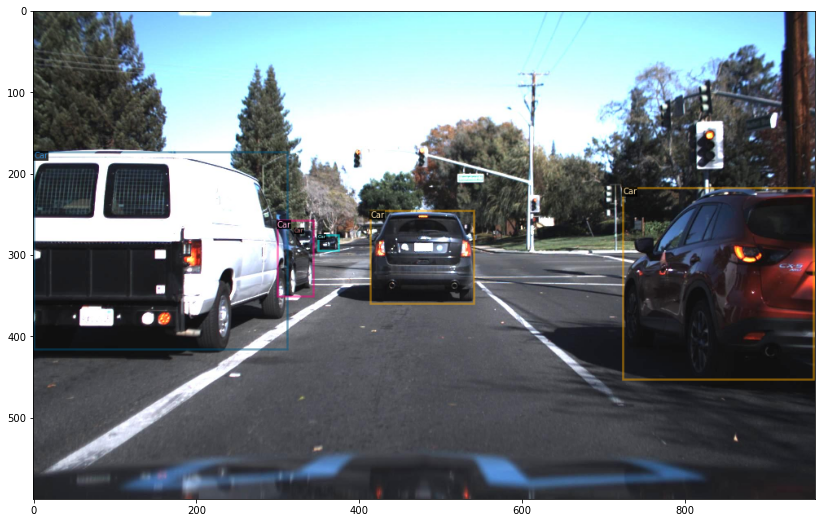

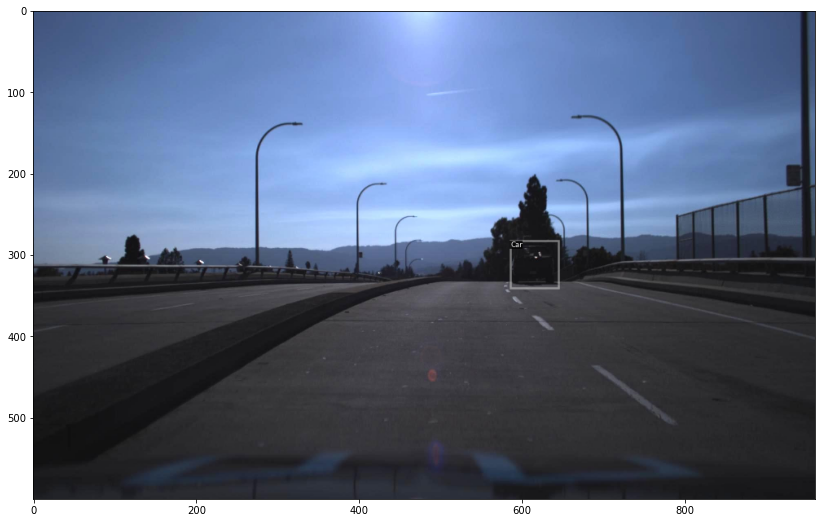

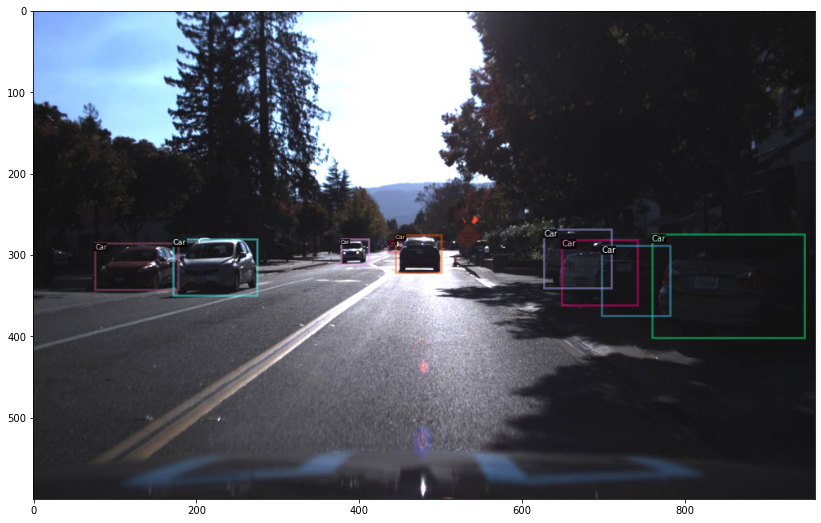

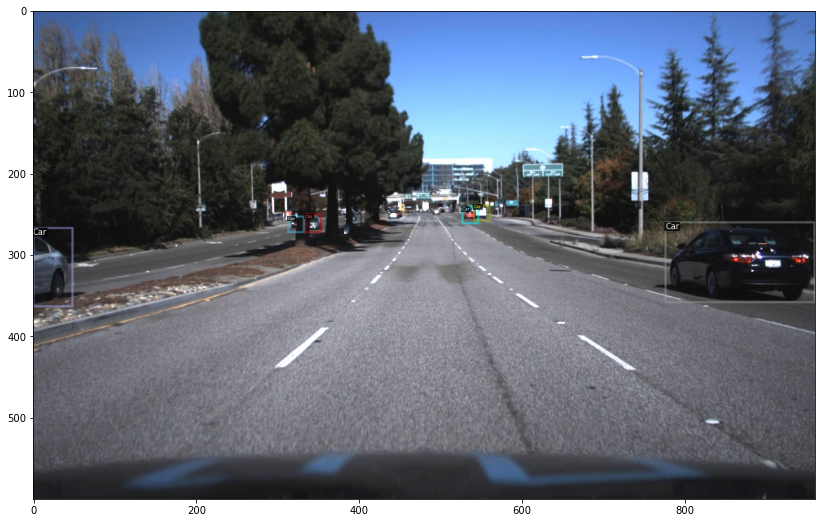

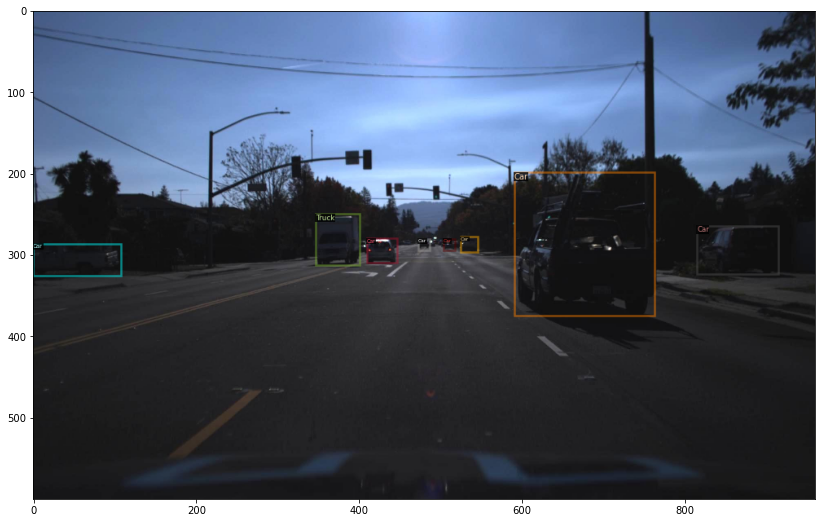

In [7]:
import random
from detectron2.utils.visualizer import Visualizer

dataset_dicts = DatasetCatalog.get('crowdai_vehicle_detection')
for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=vehicle_detection_metadata, scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [23]:
import gc
torch.cuda.empty_cache()
with torch.no_grad():
    torch.cuda.empty_cache()
gc.collect()
torch.cuda.empty_cache()

# for i, left in enumerate(dataloader):
#     print(i)
#     temp = model(left).view(-1, 1, 300, 300)
#     right.append(temp.to('cpu'))
#     del temp
#     torch.cuda.empty_cache()

In [24]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ('crowdai_vehicle_detection',)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 1
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 1
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[02/22 15:57:09 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[02/22 15:58:20 d2.data.build]: Removed 0 images with no usable annotations. 9218 images left.
[02/22 15:58:20 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[02/22 15:58:20 d2.data.build]: Using training sampler TrainingSampler
[02/22 15:58:20 d2.data.common]: Serializing 9218 elements to byte tensors and concatenating them all ...
[02/22 15:58:20 d2.data.common]: Serialized dataset takes 4.09 MiB


AssertionError: Total batch size (0.5) must be divisible by the number of gpus (1).

In [3]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import itertools
import cv2
from detectron2.config import get_cfg



# cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))

# cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")



cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   # set the testing threshold for this model
# cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4
cfg.DATASETS.TEST = ('microcontroller/test', )
predictor = DefaultPredictor(cfg)

In [3]:
# cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
# cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8   # set the testing threshold for this model
# cfg.DATASETS.TEST = ('microcontroller/test', )
# predictor = DefaultPredictor(cfg)

NameError: name 'os' is not defined

In [13]:
torch.nonzero(x, as_tuple=True)

NameError: name 'x' is not defined

In [6]:
from detectron2.utils.visualizer import ColorMode
import random
from detectron2.data import DatasetCatalog, MetadataCatalog


classes = df['Label'].unique().tolist()
DatasetCatalog.register('crowdai_vehicle_detection', lambda: get_data_dicts('labels_crowdai.csv' , 'object-detection-crowdai/'))
MetadataCatalog.get('crowdai_vehicle_detection').set(thing_classes=classes)
vehicle_detection_metadata = MetadataCatalog.get('crowdai_vehicle_detection')

dataset_dicts = DatasetCatalog.get('crowdai_vehicle_detection')
for d in random.sample(dataset_dicts, 5):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=vehicle_detection_metadata, scale=0.8)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

AssertionError: Dataset 'crowdai_vehicle_detection' is already registered!